# Overview

This Colab helps to create and validate a training set for the k-NN classifier described in the MediaPipe [Pose Classification](https://google.github.io/mediapipe/solutions/pose_classification.html) soultion, test it on an arbitrary video, export to a CSV and then use it in the [ML Kit sample app](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app).

# Step 0: Start Colab

Connect the Colab to hosted Python3 runtime (check top-right corner) and then install required dependencies.

In [2]:
# !pip install pillow==8.1.0
# !pip install matplotlib==3.3.4
# !pip install numpy==1.19.3
# !pip install opencv-python==4.5.1.48
# !pip install tqdm==4.56.0
# !pip install requests==2.25.1

# !pip install mediapipe==0.8.3

# Codebase

## Commons

In [3]:
from matplotlib import pyplot as plt


def show_image(img, figsize=(10, 10)):
  """Shows output PIL image."""
  plt.figure(figsize=figsize)
  plt.imshow(img)
  plt.show()

## Pose embedding

In [4]:
class FullBodyPoseEmbedder(object):
  """Converts 3D pose landmarks into 3D embedding."""

  def __init__(self, torso_size_multiplier=2.5):
    # Multiplier to apply to the torso to get minimal body size.
    self._torso_size_multiplier = torso_size_multiplier

    # Names of the landmarks as they appear in the prediction.
    self._landmark_names = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

  def __call__(self, landmarks):
    """Normalizes pose landmarks and converts to embedding
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances defined in `_get_pose_distance_embedding`.
    """
    assert landmarks.shape[0] == len(self._landmark_names), 'Unexpected number of landmarks: {}'.format(landmarks.shape[0])

    # Get pose landmarks.
    landmarks = np.copy(landmarks)

    # Normalize landmarks.
    landmarks = self._normalize_pose_landmarks(landmarks)

    # Get embedding.
    embedding = self._get_pose_distance_embedding(landmarks)

    return embedding

  def _normalize_pose_landmarks(self, landmarks):
    """Normalizes landmarks translation and scale."""
    landmarks = np.copy(landmarks)

    # Normalize translation.
    pose_center = self._get_pose_center(landmarks)
    landmarks -= pose_center

    # Normalize scale.
    pose_size = self._get_pose_size(landmarks, self._torso_size_multiplier)
    landmarks /= pose_size
    # Multiplication by 100 is not required, but makes it eaasier to debug.
    landmarks *= 100

    return landmarks

  def _get_pose_center(self, landmarks):
    """Calculates pose center as point between hips."""
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    center = (left_hip + right_hip) * 0.5
    return center

  def _get_pose_size(self, landmarks, torso_size_multiplier):
    """Calculates pose size.
    
    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """
    # This approach uses only 2D landmarks to compute pose size.
    landmarks = landmarks[:, :2]

    # Hips center.
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    hips = (left_hip + right_hip) * 0.5

    # Shoulders center.
    left_shoulder = landmarks[self._landmark_names.index('left_shoulder')]
    right_shoulder = landmarks[self._landmark_names.index('right_shoulder')]
    shoulders = (left_shoulder + right_shoulder) * 0.5

    # Torso size as the minimum body size.
    torso_size = np.linalg.norm(shoulders - hips)

    # Max dist to pose center.
    pose_center = self._get_pose_center(landmarks)
    max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))

    return max(torso_size * torso_size_multiplier, max_dist)

  def _get_pose_distance_embedding(self, landmarks):
    """Converts pose landmarks into 3D embedding.

    We use several pairwise 3D distances to form pose embedding. All distances
    include X and Y components with sign. We differnt types of pairs to cover
    different pose classes. Feel free to remove some or add new.
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances.
    """
    embedding = np.array([
        # One joint.

        self._get_distance(
            self._get_average_by_names(landmarks, 'left_hip', 'right_hip'),
            self._get_average_by_names(landmarks, 'left_shoulder', 'right_shoulder')),

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_elbow'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_elbow'),

        self._get_distance_by_names(landmarks, 'left_elbow', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_elbow', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_knee'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_knee', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_knee', 'right_ankle'),

        # Two joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_ankle'),

        # Four joints.

        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Five joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_ankle'),
        
        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Cross body.

        self._get_distance_by_names(landmarks, 'left_elbow', 'right_elbow'),
        self._get_distance_by_names(landmarks, 'left_knee', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_wrist', 'right_wrist'),
        self._get_distance_by_names(landmarks, 'left_ankle', 'right_ankle'),

        # Body bent direction.

        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'left_wrist', 'left_ankle'),
        #     landmarks[self._landmark_names.index('left_hip')]),
        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'right_wrist', 'right_ankle'),
        #     landmarks[self._landmark_names.index('right_hip')]),
    ])

    return embedding

  def _get_average_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return (lmk_from + lmk_to) * 0.5

  def _get_distance_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return self._get_distance(lmk_from, lmk_to)

  def _get_distance(self, lmk_from, lmk_to):
    return lmk_to - lmk_from

## Pose classification

In [5]:
class PoseSample(object):

  def __init__(self, name, landmarks, class_name, embedding):
    self.name = name
    self.landmarks = landmarks
    self.class_name = class_name
    
    self.embedding = embedding


class PoseSampleOutlier(object):

  def __init__(self, sample, detected_class, all_classes):
    self.sample = sample
    self.detected_class = detected_class
    self.all_classes = all_classes

In [6]:
import csv
import numpy as np
import os

class PoseClassifier(object):
  """Classifies pose landmarks."""

  def __init__(self,
               pose_samples_folder,
               pose_embedder,
               file_extension='csv',
               file_separator=',',
               n_landmarks=33,
               n_dimensions=3,
               top_n_by_max_distance=30,
               top_n_by_mean_distance=10,
               axes_weights=(1., 1., 0.2)):
    self._pose_embedder = pose_embedder
    self._n_landmarks = n_landmarks
    self._n_dimensions = n_dimensions
    self._top_n_by_max_distance = top_n_by_max_distance
    self._top_n_by_mean_distance = top_n_by_mean_distance
    self._axes_weights = axes_weights

    self._pose_samples = self._load_pose_samples(pose_samples_folder,
                                                 file_extension,
                                                 file_separator,
                                                 n_landmarks,
                                                 n_dimensions,
                                                 pose_embedder)

  def _load_pose_samples(self,
                         pose_samples_folder,
                         file_extension,
                         file_separator,
                         n_landmarks,
                         n_dimensions,
                         pose_embedder):
    """Loads pose samples from a given folder.
    
    Required folder structure:
      neutral_standing.csv
      pushups_down.csv
      pushups_up.csv
      squats_down.csv
      ...

    Required CSV structure:
      sample_00001,x1,y1,z1,x2,y2,z2,....
      sample_00002,x1,y1,z1,x2,y2,z2,....
      ...
    """
    # Each file in the folder represents one pose class.
    file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]
    print(file_names)
    pose_samples = []
    for file_name in file_names:
      # Use file name as pose class name.
      class_name = file_name[:-(len(file_extension) + 1)]
      print('Loading pose samples for class: {}'.format(class_name))
      # Parse CSV.
      with open(os.path.join(pose_samples_folder, file_name)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=file_separator)
        for row in csv_reader:
          # print(len(row))
          assert len(row) == n_landmarks * n_dimensions + 1, 'Wrong number of values: {}'.format(len(row))
          landmarks = np.array(row[1:], np.float32).reshape([n_landmarks, n_dimensions])
          pose_samples.append(PoseSample(
              name=row[0],
              landmarks=landmarks,
              class_name=class_name,
              embedding=pose_embedder(landmarks),
          ))

    return pose_samples

  def find_pose_sample_outliers(self):
    """Classifies each sample against the entire database."""
    # Find outliers in target poses
    outliers = []
    for sample in self._pose_samples:
      # Find nearest poses for the target one.
      pose_landmarks = sample.landmarks.copy()
      pose_classification = self.__call__(pose_landmarks)
      class_names = [class_name for class_name, count in pose_classification.items() if count == max(pose_classification.values())]

      # Sample is an outlier if nearest poses have different class or more than
      # one pose class is detected as nearest.
      if sample.class_name not in class_names or len(class_names) != 1:
        outliers.append(PoseSampleOutlier(sample, class_names, pose_classification))

    return outliers

  def __call__(self, pose_landmarks):
    """Classifies given pose.

    Classification is done in two stages:
      * First we pick top-N samples by MAX distance. It allows to remove samples
        that are almost the same as given pose, but has few joints bent in the
        other direction.
      * Then we pick top-N samples by MEAN distance. After outliers are removed
        on a previous step, we can pick samples that are closes on average.
    
    Args:
      pose_landmarks: NumPy array with 3D landmarks of shape (N, 3).

    Returns:
      Dictionary with count of nearest pose samples from the database. Sample:
        {
          'pushups_down': 8,
          'pushups_up': 2,
        }
    """
    # Check that provided and target poses have the same shape.
    assert pose_landmarks.shape == (self._n_landmarks, self._n_dimensions), 'Unexpected shape: {}'.format(pose_landmarks.shape)

    # Get given pose embedding.
    pose_embedding = self._pose_embedder(pose_landmarks)
    flipped_pose_embedding = self._pose_embedder(pose_landmarks * np.array([-1, 1, 1]))

    # Filter by max distance.
    #
    # That helps to remove outliers - poses that are almost the same as the
    # given one, but has one joint bent into another direction and actually
    # represnt a different pose class.
    max_dist_heap = []
    for sample_idx, sample in enumerate(self._pose_samples):
      max_dist = min(
          np.max(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
          np.max(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
      )
      max_dist_heap.append([max_dist, sample_idx])

    max_dist_heap = sorted(max_dist_heap, key=lambda x: x[0])
    max_dist_heap = max_dist_heap[:self._top_n_by_max_distance]

    # Filter by mean distance.
    #
    # After removing outliers we can find the nearest pose by mean distance.
    mean_dist_heap = []
    for _, sample_idx in max_dist_heap:
      sample = self._pose_samples[sample_idx]
      mean_dist = min(
          np.mean(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
          np.mean(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
      )
      mean_dist_heap.append([mean_dist, sample_idx])

    mean_dist_heap = sorted(mean_dist_heap, key=lambda x: x[0])
    mean_dist_heap = mean_dist_heap[:self._top_n_by_mean_distance]

    # Collect results into map: (class_name -> n_samples)
    class_names = [self._pose_samples[sample_idx].class_name for _, sample_idx in mean_dist_heap]
    result = {class_name: class_names.count(class_name) for class_name in set(class_names)}

    return result

## Classification smoothing

In [7]:
class EMADictSmoothing(object):
  """Smoothes pose classification."""

  def __init__(self, window_size=10, alpha=0.2):
    self._window_size = window_size
    self._alpha = alpha

    self._data_in_window = []

  def __call__(self, data):
    """Smoothes given pose classification.

    Smoothing is done by computing Exponential Moving Average for every pose
    class observed in the given time window. Missed pose classes arre replaced
    with 0.
    
    Args:
      data: Dictionary with pose classification. Sample:
          {
            'pushups_down': 8,
            'pushups_up': 2,
          }

    Result:
      Dictionary in the same format but with smoothed and float instead of
      integer values. Sample:
        {
          'pushups_down': 8.3,
          'pushups_up': 1.7,
        }
    """
    # Add new data to the beginning of the window for simpler code.
    self._data_in_window.insert(0, data)
    self._data_in_window = self._data_in_window[:self._window_size]

    # Get all keys.
    keys = set([key for data in self._data_in_window for key, _ in data.items()])

    # Get smoothed values.
    smoothed_data = dict()
    for key in keys:
      factor = 1.0
      top_sum = 0.0
      bottom_sum = 0.0
      for data in self._data_in_window:
        value = data[key] if key in data else 0.0

        top_sum += factor * value
        bottom_sum += factor

        # Update factor.
        factor *= (1.0 - self._alpha)

      smoothed_data[key] = top_sum / bottom_sum

    return smoothed_data

## Repetition counter

In [8]:
class RepetitionCounter(object):
  """Counts number of repetitions of given target pose class."""

  def __init__(self, class_name, enter_threshold=6, exit_threshold=4):
    self._class_name = class_name

    # If pose counter passes given threshold, then we enter the pose.
    self._enter_threshold = enter_threshold
    self._exit_threshold = exit_threshold

    # Either we are in given pose or not.
    self._pose_entered = False

    # Number of times we exited the pose.
    self._n_repeats = 0

  @property
  def n_repeats(self):
    return self._n_repeats

  def __call__(self, pose_classification):
    """Counts number of repetitions happend until given frame.

    We use two thresholds. First you need to go above the higher one to enter
    the pose, and then you need to go below the lower one to exit it. Difference
    between the thresholds makes it stable to prediction jittering (which will
    cause wrong counts in case of having only one threshold).
    
    Args:
      pose_classification: Pose classification dictionary on current frame.
        Sample:
          {
            'pushups_down': 8.3,
            'pushups_up': 1.7,
          }

    Returns:
      Integer counter of repetitions.
    """
    # Get pose confidence.
    pose_confidence = 0.0
    if self._class_name in pose_classification:
      pose_confidence = pose_classification[self._class_name]

    # On the very first frame or if we were out of the pose, just check if we
    # entered it on this frame and update the state.
    if not self._pose_entered:
      self._pose_entered = pose_confidence > self._enter_threshold
      return self._n_repeats

    # If we were in the pose and are exiting it, then increase the counter and
    # update the state.
    if pose_confidence < self._exit_threshold:
      self._n_repeats += 1
      self._pose_entered = False

    return self._n_repeats

## Classification visualizer

In [9]:
import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import requests

class PoseClassificationVisualizer(object):
  """Keeps track of claassifcations for every frame and renders them."""

  def __init__(self,
               class_name,
               plot_location_x=0.05,
               plot_location_y=0.05,
               plot_max_width=0.4,
               plot_max_height=0.4,
               plot_figsize=(9, 4),
               plot_x_max=None,
               plot_y_max=None,
               counter_location_x=0.85,
               counter_location_y=0.05,
              #  counter_font_path='https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true',
               counter_font_color='red',
               counter_font_size=0.15):
    self._class_name = class_name
    self._plot_location_x = plot_location_x
    self._plot_location_y = plot_location_y
    self._plot_max_width = plot_max_width
    self._plot_max_height = plot_max_height
    self._plot_figsize = plot_figsize
    self._plot_x_max = plot_x_max
    self._plot_y_max = plot_y_max
    self._counter_location_x = counter_location_x
    self._counter_location_y = counter_location_y
    # self._counter_font_path = counter_font_path
    self._counter_font_color = counter_font_color
    self._counter_font_size = counter_font_size

    self._counter_font = None

    self._pose_classification_history = []
    self._pose_classification_filtered_history = []

  def __call__(self,
               frame,
               pose_classification,
               pose_classification_filtered,
               repetitions_count):
    """Renders pose classifcation and counter until given frame."""
    # Extend classification history.
    self._pose_classification_history.append(pose_classification)
    self._pose_classification_filtered_history.append(pose_classification_filtered)

    # Output frame with classification plot and counter.
    output_img = Image.fromarray(frame)

    output_width = output_img.size[0]
    output_height = output_img.size[1]

    # Draw the plot.
    img = self._plot_classification_history(output_width, output_height)
    img.thumbnail((int(output_width * self._plot_max_width),
                   int(output_height * self._plot_max_height)),
                  Image.ANTIALIAS)
    output_img.paste(img,
                     (int(output_width * self._plot_location_x),
                      int(output_height * self._plot_location_y)))

    # Draw the count.
    output_img_draw = ImageDraw.Draw(output_img)
    if self._counter_font is None:
      font_size = int(output_height * self._counter_font_size)
      # font_request = requests.get(self._counter_font_path, allow_redirects=True)
      # self._counter_font = ImageFont.truetype(io.BytesIO(font_request.content), size=font_size)
    output_img_draw.text((output_width * self._counter_location_x,
                          output_height * self._counter_location_y),
                         str(repetitions_count),
                        #  font=self._counter_font,
                         fill=self._counter_font_color)

    return output_img

  def _plot_classification_history(self, output_width, output_height):
    fig = plt.figure(figsize=self._plot_figsize)

    for classification_history in [self._pose_classification_history,
                                   self._pose_classification_filtered_history]:
      y = []
      for classification in classification_history:
        if classification is None:
          y.append(None)
        elif self._class_name in classification:
          y.append(classification[self._class_name])
        else:
          y.append(0)
      plt.plot(y, linewidth=7)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Frame')
    plt.ylabel('Confidence')
    plt.title('Classification history for `{}`'.format(self._class_name))
    plt.legend(loc='upper right')

    if self._plot_y_max is not None:
      plt.ylim(top=self._plot_y_max)
    if self._plot_x_max is not None:
      plt.xlim(right=self._plot_x_max)

    # Convert plot to image.
    buf = io.BytesIO()
    dpi = min(
        output_width * self._plot_max_width / float(self._plot_figsize[0]),
        output_height * self._plot_max_height / float(self._plot_figsize[1]))
    fig.savefig(buf, dpi=dpi)
    buf.seek(0)
    img = Image.open(buf)
    plt.close()

    return img

## Bootstrap helper

In [10]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import sys
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose


class BootstrapHelper(object):
  """Helps to bootstrap images and filter pose samples for classification."""

  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_folder):
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_folder = csvs_out_folder

    # Get list of pose classes and print image statistics.
    self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])
    
  def bootstrap(self, per_pose_class_limit=None):
    """Bootstraps images in a given folder.
    
    Required image in folder (same use for image out folder):
      pushups_up/
        image_001.jpg
        image_002.jpg
        ...
      pushups_down/
        image_001.jpg
        image_002.jpg
        ...
      ...

    Produced CSVs out folder:
      pushups_up.csv
      pushups_down.csv

    Produced CSV structure with pose 3D landmarks:
      sample_00001,x1,y1,z1,x2,y2,z2,....
      sample_00002,x1,y1,z1,x2,y2,z2,....
    """
    # Create output folder for CVSs.
    if not os.path.exists(self._csvs_out_folder):
      os.makedirs(self._csvs_out_folder)

    for pose_class_name in self._pose_class_names:
      print('Bootstrapping ', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder, pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        # Get list of images.
        image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        # Bootstrap every image.
        for image_name in tqdm.tqdm(image_names):
          # Load image.
          input_frame = cv2.imread(os.path.join(images_in_folder, image_name))
          input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

          # Initialize fresh pose tracker and run it.
          with mp_pose.Pose() as pose_tracker:
            result = pose_tracker.process(image=input_frame)
            pose_landmarks = result.pose_landmarks

          # Save image with pose prediction (if pose was detected).
          output_frame = input_frame.copy()
          if pose_landmarks is not None:
            mp_drawing.draw_landmarks(
                image=output_frame,
                landmark_list=pose_landmarks,
                connections=mp_pose.POSE_CONNECTIONS)
          output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
          
          # Save landmarks if pose was detected.
          if pose_landmarks is not None:
            # Get landmarks.
            frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
            pose_landmarks = np.array(
                [[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                 for lmk in pose_landmarks.landmark],
                dtype=np.float32)
            assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)
            # print(image_name)
            csv_out_writer.writerow([image_name] + pose_landmarks.flatten().astype(np.str).tolist())

          # Draw XZ projection and concatenate with the image.
          projection_xz = self._draw_xz_projection(
              output_frame=output_frame, pose_landmarks=pose_landmarks)
          output_frame = np.concatenate((output_frame, projection_xz), axis=1)

  def _draw_xz_projection(self, output_frame, pose_landmarks, r=0.5, color='red'):
    frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
    img = Image.new('RGB', (frame_width, frame_height), color='white')

    if pose_landmarks is None:
      return np.asarray(img)

    # Scale radius according to the image width.
    r *= frame_width * 0.01

    draw = ImageDraw.Draw(img)
    for idx_1, idx_2 in mp_pose.POSE_CONNECTIONS:
      # Flip Z and move hips center to the center of the image.
      x1, y1, z1 = pose_landmarks[idx_1] * [1, 1, -1] + [0, 0, frame_height * 0.5]
      x2, y2, z2 = pose_landmarks[idx_2] * [1, 1, -1] + [0, 0, frame_height * 0.5]

      draw.ellipse([x1 - r, z1 - r, x1 + r, z1 + r], fill=color)
      draw.ellipse([x2 - r, z2 - r, x2 + r, z2 + r], fill=color)
      draw.line([x1, z1, x2, z2], width=int(r), fill=color)

    return np.asarray(img)

  def align_images_and_csvs(self, print_removed_items=False):
    """Makes sure that image folders and CSVs have the same sample.
    
    Leaves only intersetion of samples in both image folders and CSVs.
    """
    for pose_class_name in self._pose_class_names:
      # Paths for the pose class.
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder, pose_class_name + '.csv')

      # Read CSV into memory.
      rows = []
      with open(csv_out_path) as csv_out_file:
        csv_out_reader = csv.reader(csv_out_file, delimiter=',')
        for row in csv_out_reader:
          rows.append(row)
      print('CSV rows before alignment: ', len(rows))
      # Image names left in CSV.
      image_names_in_csv = []

      # Re-write the CSV removing lines without corresponding images.
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for row in rows:
          image_name = row[0]
          image_path = os.path.join(images_out_folder, image_name)
          if os.path.exists(image_path):
            image_names_in_csv.append(image_name)
            csv_out_writer.writerow(row)
          elif print_removed_items:
            print('Removed image from CSV: ', image_path)

      # Remove images without corresponding line in CSV.
      for image_name in os.listdir(images_out_folder):
        if image_name not in image_names_in_csv:
          image_path = os.path.join(images_out_folder, image_name)
          os.remove(image_path)
          if print_removed_items:
            print('Removed image from folder: ', image_path)

  def analyze_outliers(self, outliers):
    """Classifies each sample agains all other to find outliers.
    
    If sample is classified differrrently than the original class - it sould
    either be deleted or more similar samples should be aadded.
    """
    for outlier in outliers:
      image_path = os.path.join(self._images_out_folder, outlier.sample.class_name, outlier.sample.name)

      print('Outlier')
      print('  sample path =    ', image_path)
      print('  sample class =   ', outlier.sample.class_name)
      print('  detected class = ', outlier.detected_class)
      print('  all classes =    ', outlier.all_classes)

      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      show_image(img, figsize=(20, 20))

  def remove_outliers(self, outliers):
    """Removes outliers from the image folders."""
    for outlier in outliers:
      image_path = os.path.join(self._images_out_folder, outlier.sample.class_name, outlier.sample.name)
      os.remove(image_path)

  def print_images_in_statistics(self):
    """Prints statistics from the input image folder."""
    self._print_images_statistics(self._images_in_folder, self._pose_class_names)

  def print_images_out_statistics(self):
    """Prints statistics from the output image folder."""
    self._print_images_statistics(self._images_out_folder, self._pose_class_names)

  def _print_images_statistics(self, images_folder, pose_class_names):
    print('Number of images per pose class:')
    for pose_class_name in pose_class_names:
      n_images = len([
          n for n in os.listdir(os.path.join(images_folder, pose_class_name))
          if not n.startswith('.')])
      print('  {}: {}'.format(pose_class_name, n_images))

# Step 1: Build classifier

## Upload image samples

Locally create a folder named `fitness_poses_images_in` with image samples.

Images should repesent terminal states of desired pose classes. I.e. if you want to classify push-up provide iamges for two classes: when person is up, and when person is down.

There should be about a few hundred samples per class covering different camera angles, environment conditions, body shapes, and exercise variations to build a good classifier.

Required structure of the images_in_folder:
```
fitness_poses_images_in/
  pushups_up/
    image_001.jpg
    image_002.jpg
    ...
  pushups_down/
    image_001.jpg
    image_002.jpg
    ...
  ...
```

Zip the `fitness_poses_images_in` folder:
```
zip -r fitness_poses_images_in.zip fitness_poses_images_in
```

And run the code below to upload it to the Colab runtime

In [11]:
# from google.colab import files
# import os

# uploaded = files.upload()
# os.listdir('.')

In [12]:
# filepath = "D:/Coding/Project/minor2/first/squats.zip"

In [13]:
# import zipfile
# import io

# # WE will be taking the file from local storage
# with open(filepath, 'rb') as file:
#     zf = zipfile.ZipFile(file)

#     zf.extractall()
# os.listdir('.')

Unzip the archive:

In [14]:


# zf = zipfile.ZipFile(io.BytesIO(uploaded['fitness_poses_images_in.zip']), "r")


## Bootstrap images

In [15]:
# Required structure of the images_in_folder:
#
#   fitness_poses_images_in/
#     pushups_up/
#       image_001.jpg
#       image_002.jpg
#       ...
#     pushups_down/
#       image_001.jpg
#       image_002.jpg
#       ...
#     ...
bootstrap_images_in_folder = 'fitness_poses_images_in'

# Output folders for bootstrapped images and CSVs.
bootstrap_images_out_folder = 'fitness_poses_images_out'
bootstrap_csvs_out_folder = 'fitness_poses_csvs_out'

In [16]:
# Initialize helper.
bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
)

In [17]:
# Check how many pose classes and images for them are available.
bootstrap_helper.print_images_in_statistics()

Number of images per pose class:
  squat_down: 341
  squat_up: 458


In [18]:
# Bootstrap all images.
# Set limit to some small number for debug.
bootstrap_helper.bootstrap(per_pose_class_limit=None)

Bootstrapping  squat_down
  0%|          | 0/341 [00:00<?, ?it/s]C:\Users\Mukul\AppData\Local\Temp\ipykernel_2652\59647892.py:101: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  csv_out_writer.writerow([image_name] + pose_landmarks.flatten().astype(np.str).tolist())
100%|██████████| 341/341 [02:03<00:00,  2.75it/s]
Bootstrapping  squat_up
100%|██████████| 458/458 [02:13<00:00,  3.43it/s]


In [19]:
# Check how many images were bootstrapped.
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  squat_down: 341
  squat_up: 458


In [20]:
bootstrap_helper.align_images_and_csvs(print_removed_items=True)


CSV rows before alignment:  334
Removed image from folder:  fitness_poses_images_out\squat_down\squat_100091.jpg
Removed image from folder:  fitness_poses_images_out\squat_down\squat_1200051.jpg
Removed image from folder:  fitness_poses_images_out\squat_down\squat_1200061.jpg
Removed image from folder:  fitness_poses_images_out\squat_down\squat_200121.jpg
Removed image from folder:  fitness_poses_images_out\squat_down\squat_400211.jpg
Removed image from folder:  fitness_poses_images_out\squat_down\squat_700011.jpg
Removed image from folder:  fitness_poses_images_out\squat_down\squat_900031.jpg
CSV rows before alignment:  439
Removed image from folder:  fitness_poses_images_out\squat_up\squat_1000091.jpg
Removed image from folder:  fitness_poses_images_out\squat_up\squat_1000101.jpg
Removed image from folder:  fitness_poses_images_out\squat_up\squat_1500101.jpg
Removed image from folder:  fitness_poses_images_out\squat_up\squat_1500201.jpg
Removed image from folder:  fitness_poses_image

In [21]:
# After initial bootstrapping images without detected poses were still saved in
# the folderd (but not in the CSVs) for debug purpose. Let's remove them.
# bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  squat_down: 334
  squat_up: 439


## Manual filtration

Please manually verify predictions and remove samples (images) that has wrong pose prediction. Check as if you were asked to classify pose just from predicted landmarks. If you can't - remove it.

Align CSVs and image folders once you are done.

In [22]:
# Align CSVs with filtered images.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

CSV rows before alignment:  334
CSV rows before alignment:  439
Number of images per pose class:
  squat_down: 334
  squat_up: 439


## Automatic filtration

Classify each sample against database of all other samples and check if it gets in the same class as annotated after classification.

There can be two reasons for the outliers:

  * **Wrong pose prediction**: In this case remove such outliers.

  * **Wrong classification** (i.e. pose is predicted correctly and you aggree with original pose class assigned to the sample): In this case sample is from the underrepresented group (e.g. unusual angle or just very few samples). Add more similar samples and run bootstrapping from the very beginning.

Even if you just removed some samples it makes sence to re-run automatic filtration one more time as database of poses has changed.

**Important!!** Check that you are using the same parameters when classifying whole videos later.

In [23]:
# Find outliers.

# Transforms pose landmarks into embedding.
pose_embedder = FullBodyPoseEmbedder()

# Classifies give pose against database of poses.
pose_classifier = PoseClassifier(
    pose_samples_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

outliers = pose_classifier.find_pose_sample_outliers()
print('Number of outliers: ', len(outliers))

['squat_down.csv', 'squat_up.csv']
Loading pose samples for class: squat_down
Loading pose samples for class: squat_up
Number of outliers:  49


In [24]:
# Analyze outliers.
# bootstrap_helper.analyze_outliers(outliers)

In [25]:
# Remove all outliers (if you don't want to manually pick).
bootstrap_helper.remove_outliers(outliers)

In [26]:
# Align CSVs with images after removing outliers.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

CSV rows before alignment:  334
CSV rows before alignment:  439
Number of images per pose class:
  squat_down: 294
  squat_up: 430


## Dump for the App

Dump filtered poses to CSV and download it.

Please check this [guide](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app) on how to use this CSV in the ML Kit sample app.

In [27]:
import csv
import os
import numpy as np


def dump_for_the_app():
  pose_samples_folder = 'fitness_poses_csvs_out'
  pose_samples_csv_path = 'fitness_poses_csvs_out.csv'
  file_extension = 'csv'
  file_separator = ','

  # Each file in the folder represents one pose class.
  file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

  with open(pose_samples_csv_path, 'w') as csv_out:
    csv_out_writer = csv.writer(csv_out, delimiter=file_separator, quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    for file_name in file_names:
      # Use file name as pose class name.
      class_name = file_name[:-(len(file_extension) + 1)]

      # One file line: `sample_00001,x1,y1,x2,y2,....`.
      with open(os.path.join(pose_samples_folder, file_name)) as csv_in:
        csv_in_reader = csv.reader(csv_in, delimiter=file_separator)
        for row in csv_in_reader:
          row.insert(1, class_name)
          csv_out_writer.writerow(row)

  # files.download(pose_samples_csv_path)


dump_for_the_app()

# Step 2: Classification

**Important!!** Check that you are using the same classification parameters as while building classifier.

In [28]:
# # Upload your video.
# uploaded = files.upload()
# os.listdir('.')

In [29]:
# Specify your video name and target pose class to count the repetitions.
video_path = 'squats.mp4'
class_name='pushups_down'
out_video_path = 'squats_out.mp4'

In [30]:
# Open the video.
import cv2

video_cap = cv2.VideoCapture(0)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [31]:
print('Video n_frames: ', video_n_frames)
print('Video fps: ', video_fps)
print('Video width: ', video_width)
print('Video height: ', video_height)


Video n_frames:  -1.0
Video fps:  30.0
Video width:  640
Video height:  480


In [32]:
# Initilize tracker, classifier and counter.
# Do that before every video as all of them have state.
from mediapipe.python.solutions import pose as mp_pose


# Folder with pose class CSVs. That should be the same folder you using while
# building classifier to output CSVs.
pose_samples_folder = 'fitness_poses_csvs_out'

# Initialize tracker.
pose_tracker = mp_pose.Pose()

# Initialize embedder.
pose_embedder = FullBodyPoseEmbedder()

# Initialize classifier.
# Ceck that you are using the same parameters as during bootstrapping.
pose_classifier = PoseClassifier(
    pose_samples_folder=pose_samples_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

# # Uncomment to validate target poses used by classifier and find outliers.
# outliers = pose_classifier.find_pose_sample_outliers()
# print('Number of pose sample outliers (consider removing them): ', len(outliers))

# Initialize EMA smoothing.
pose_classification_filter = EMADictSmoothing(
    window_size=10,
    alpha=0.2)

# Initialize counter.
repetition_counter = RepetitionCounter(
    class_name="squats",
    enter_threshold=5,
    exit_threshold=5)

# Initialize renderer.
pose_classification_visualizer = PoseClassificationVisualizer(
    class_name=class_name,
    plot_x_max=video_n_frames,
    # Graphic looks nicer if it's the same as `top_n_by_mean_distance`.
    plot_y_max=10)

['squat_down.csv', 'squat_up.csv']
Loading pose samples for class: squat_down
Loading pose samples for class: squat_up


In [ ]:
# Run classification on a video.
import os
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing


# Open output video.
# out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (video_width, video_height))

frame_idx = 0
output_frame = None
# with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
while True:
    # Get next frame of the video.
    success, input_frame = video_cap.read()
    if not success:
        break

    # Run pose tracker.
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    result = pose_tracker.process(image=input_frame)
    pose_landmarks = result.pose_landmarks

    # Draw pose prediction.
    output_frame = input_frame.copy()
    if pose_landmarks is not None:
        mp_drawing.draw_landmarks(
            image=output_frame,
            landmark_list=pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS)

    if pose_landmarks is not None:
        # Get landmarks.
        print("yes", end=" ")
        frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
        pose_landmarks = np.array([[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                    for lmk in pose_landmarks.landmark], dtype=np.float32)
        assert pose_landmarks.shape == (
            33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)

        # Classify the pose on the current frame.
        pose_classification = pose_classifier(pose_landmarks)

        # Smooth classification using EMA.
        pose_classification_filtered = pose_classification_filter(
            pose_classification)

        # Count repetitions.
        repetitions_count = repetition_counter(
            pose_classification_filtered)
    else:
        # No pose => no classification on current frame.
        print("no", end=" ")
        pose_classification = None

        # Still add empty classification to the filter to maintaing correct
        # smoothing for future frames.
        pose_classification_filtered = pose_classification_filter(dict())
        pose_classification_filtered = None

        # Don't update the counter presuming that person is 'frozen'. Just
        # take the latest repetitions count.
        repetitions_count = repetition_counter.n_repeats

    # Draw classification plot and repetition counter.
    output_frame = pose_classification_visualizer(
        frame=output_frame,
        pose_classification=pose_classification,
        pose_classification_filtered=pose_classification_filtered,
        repetitions_count=repetitions_count)

    # Save the output frame.
    # out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))
    # cv2.imshow('out',np.array(output_frame))

    cv2.imshow("Output Frame", cv2.cvtColor(
        np.array(output_frame), cv2.COLOR_RGB2BGR))
    cv2.waitKey(1)  # wait for 1 millisecond to display the frame

    # Show intermediate frames of the video to track progress.
    # if frame_idx % 50 == 0:
    #   show_image(output_frame)

    # frame_idx += 1
    # pbar.update()

# Close output video.
# out_video.release()

# Release MediaPipe resources.
pose_tracker.close()

# Show the last frame of the video.
# if output_frame is not None:
#   show_image(output_frame)


In [ ]:
# # Download generated video
# files.download(out_video_path)

In [1]:
import pandas as pd

# Load squat_down.csv and drop column by index
df1 = pd.read_csv("fitness_poses_csvs_out/squat_down.csv", header=None)
df1 = df1.drop(df1.columns[0], axis=1)

# Load squat_up.csv and drop column by index

df2 = pd.read_csv("fitness_poses_csvs_out/squat_up.csv", header=None)
df2 = df2.drop(df2.columns[0], axis=1)

# Add new column to each dataframe with output values
df1['output'] = 0
df2['output'] = 1

# Merge the two dataframes
merged_df = pd.concat([df1, df2], ignore_index=True)

merged_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,output
719,217.33950,69.930330,221.827320,214.96307,64.404785,209.653430,213.20087,64.180410,209.670100,211.51204,...,228.55939,315.67258,-206.10582,183.69559,314.07092,-88.018860,241.46988,310.97446,-227.28603,1
720,215.93027,47.135242,222.575320,213.58563,43.402767,205.349780,211.56517,43.345036,205.367100,209.41023,...,229.56288,318.58023,-148.00461,182.76450,316.18408,-80.743866,237.66260,315.14145,-177.63577,1
721,215.48335,45.472164,204.094310,212.67600,41.871407,185.577270,210.52443,41.880130,185.598920,208.27477,...,229.92235,320.17900,-118.05789,181.55849,313.91006,-74.872116,237.74905,316.49510,-140.67232,1
722,303.40112,70.304504,4.294653,304.50427,69.089290,19.186293,304.87033,69.943750,19.139387,305.16058,...,239.59130,333.77243,-86.16709,263.22192,354.02524,-84.980210,243.81421,356.89600,-145.61716,1
723,277.85355,13.889380,-51.286550,283.17420,8.899022,-74.208970,282.97955,9.398107,-74.220240,282.77310,...,286.70743,351.78940,310.26007,236.86660,394.19470,-41.384205,261.76828,367.49713,301.71518,1


In [2]:
import glob
import os

# specify the directory you want to search for .csv files
directory = '.'

# use glob.glob() to get a list of file names matching the extension .csv
csv_files = glob.glob(directory + '/*.csv')

# use os.path.basename() to extract only the file name from each path
csv_file_names = [os.path.basename(file) for file in csv_files]

# print the list of .csv file names
print(csv_file_names)

['data.csv', 'fitness_poses_csvs_out.csv']


In [3]:
merged_df_reversed = merged_df.iloc[::-1]
merged_df_reversed.reset_index(drop=True, inplace=True)
result = merged_df_reversed.sub(merged_df)
result.tail()


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,output
719,1284.98120,1762.389670,-544.767820,1314.91483,1726.921015,-606.224330,1324.56813,1726.244190,-606.195670,1335.06326,...,1612.91031,2991.67262,936.89472,1360.30261,3042.10068,-340.804740,1355.78532,3018.10654,870.33553,-1
720,1283.60673,1841.347758,-1420.795320,1308.97957,1798.612833,-1438.694580,1322.11743,1795.601264,-1438.521600,1337.19757,...,1358.42642,2951.54457,475.23575,1530.46100,3063.33862,-1450.509834,1151.04480,3009.30555,211.41973,-1
721,1336.10615,1975.680536,-1511.572610,1361.16260,1920.246593,-1492.272070,1380.10157,1914.720470,-1492.043920,1400.03253,...,1352.86905,2952.60540,520.65389,1510.19701,3070.94594,-1532.885184,1155.39485,3013.42750,260.20499,-1
722,1225.62078,1782.866496,-1290.903153,1248.86743,1738.788610,-1299.578593,1263.38577,1736.599550,-1299.415887,1279.77402,...,1361.80690,2944.22607,122.05441,1443.19368,3052.52506,-1720.598790,1139.35989,2976.08740,-190.72192,-1
723,1374.41545,1916.902720,-969.341150,1394.58720,1873.950378,-869.456860,1413.52645,1872.894893,-869.598420,1428.18380,...,1250.55217,2912.83680,-1051.56012,1573.66770,2970.51870,-1414.006895,1198.54322,2988.82567,-1609.28018,-1


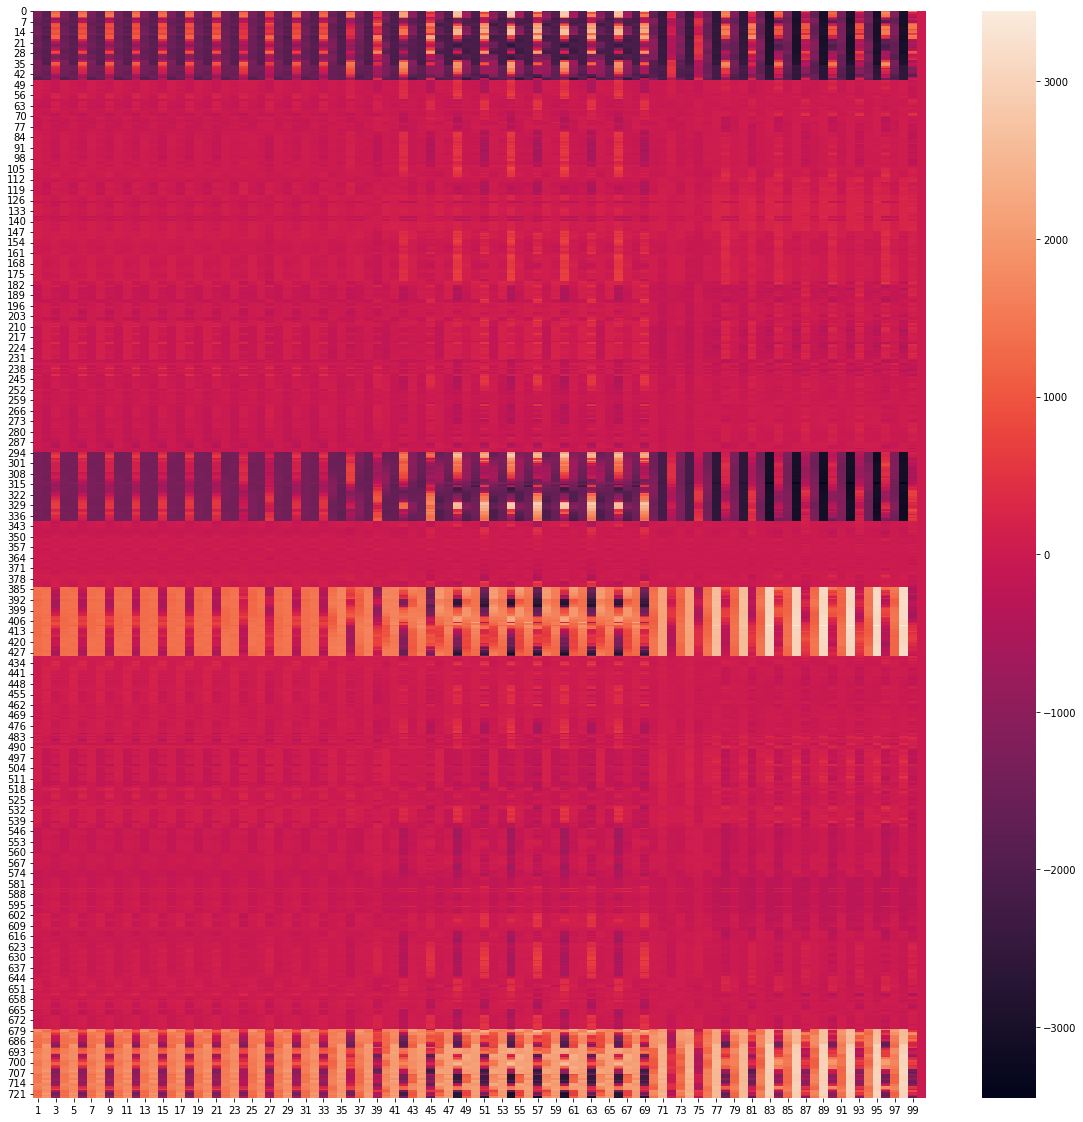

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a random dataframe
# data = pd.DataFrame(np.random.rand(10, 10))

# Create the heatmap
fig, ax = plt.subplots(figsize=(20,20))
# sns.heatmap(df, ax=ax)
sns.heatmap(result, ax=ax)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(merged_df.iloc[:, :-1], merged_df.iloc[:, -1], test_size=0.5, random_state=12)



In [7]:
# Train the SVM model
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train, y_train)

# Evaluate the model on the testing set
accuracy = svm_model.score(X_test, y_test)
print('Accuracy:', accuracy)

Accuracy: 0.9530386740331491


In [8]:
import numpy as np

# Select the first row of merged_df as a test sample
test_sample = np.array(merged_df.iloc[0, :-1]).reshape(1, -1)

# Use the trained SVM model to predict the output
prediction = svm_model.predict(test_sample)

# Print the predicted output
print(prediction)

[0]


In [9]:
import os
import numpy as np
import pandas as pd

In [10]:
data_folder = "fitness_poses_csvs_out"

# Load the CSV files into Pandas dataframes
df1 = pd.read_csv(os.path.join(data_folder, "squat_down.csv"))
df2 = pd.read_csv(os.path.join(data_folder, "squat_up.csv"))

In [11]:


# Remove the image name column from both dataframes
df1 = df1.iloc[:, 1:]
df2 = df2.iloc[:, 1:]



In [12]:
# Concatenate both dataframes into a single dataframe
# df = pd.concat([df1, df2])

# Compute the mean and standard deviation for each column
mean = df1.mean()
std = df1.std()

# Compute the z-score for each value in the dataframe
z_scores = (df1 - mean) / std

# Find the outliers using a threshold value
threshold = 3.0
outliers = np.abs(z_scores) > threshold
# np.abs(z_scores) > threshold
outlier_indices = np.where(z_scores > threshold)

# Print the indices of the outliers.
print(outlier_indices)

# # Print the number of outliers for each column
# print("Number of outliers in each column:")
# print(outliers.sum(axis=0))

# # Print the number of outliers for each class
# print("Number of outliers in each class:")
# print(outliers.sum(axis=1).groupby(df1.index < len(df1)).sum())
mean = df2.mean()
std = df2.std()

# Compute the z-score for each value in the dataframe
z_scores = (df2 - mean) / std

# Find the outliers using a threshold value
threshold = 3.0

outlier_indices = np.where(z_scores > threshold)

# Print the indices of the outliers.
print(outlier_indices)

# outliers = np.abs(z_scores) > threshold

# # Print the number of outliers for each column
# print("Number of outliers in each column:")
# print(outliers.sum(axis=0))

# # Print the number of outliers for each class
# print("Number of outliers in each class:")
# print(outliers.sum(axis=1).groupby(df2.index < len(df1)).sum())

(array([ 3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  6,  6,  6,
        7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8, 15, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20,
       20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 32, 32, 32, 33, 35, 36, 36, 36, 36, 37, 37, 37, 37, 37,
       37, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40,
       41, 41, 41, 41, 4

In [13]:
from scipy.stats import zscore

In [14]:
df1 = df1.iloc[:, 1:]
df2 = df2.iloc[:, 1:]

In [15]:
df1.head()

,1930.7921,-1020.6277,1677.7614,1882.8494,-943.66583,1696.506,1882.293,-943.81866,1710.9569,1882.3572,...,-855.972,1537.2596,3264.6262,-741.30005,1810.5343,3364.7134,-1455.3911,1460.3115,3356.3228,-1307.565
0,1853.1710,-1286.6085,1553.3717,1807.8779,-1280.3923,1568.2561,1806.5433,-1280.27650,1584.9346,1805.1909,...,-1266.1120,1601.3982,3277.9985,35.887320,1706.4156,3406.5503,-1805.5790,1383.1741,3332.9834,-336.33908
1,2021.1527,-1307.4783,1573.8386,1962.1180,-1306.6948,1590.6260,1956.6006,-1306.44500,1608.3073,1951.2703,...,-1165.5331,1582.7914,3272.7844,402.596000,1691.7555,3384.8560,-1607.7573,1393.1439,3329.9226,119.53267
2,1888.4830,-1198.2200,1522.5652,1842.0156,-1233.3448,1533.6826,1838.9463,-1233.15450,1546.6078,1835.6158,...,-1039.5448,1587.9893,3270.1248,327.231140,1713.2255,3379.5227,-1531.2537,1388.7074,3324.4470,33.78396
3,1832.3200,-322.9405,1529.8779,1791.3258,-396.5709,1537.7690,1790.4246,-396.52557,1546.5753,1789.5686,...,-309.2568,1841.4697,3307.3452,730.788900,1543.9982,3356.1716,-428.8236,1597.2552,3329.0810,643.04950
4,1829.0040,1071.2877,1732.8397,1794.7546,996.8955,1720.7250,1793.9163,996.66740,1709.7424,1793.7266,...,773.3980,1834.5409,3345.0247,-62.008366,1566.1652,3252.8425,729.6390,2011.5002,3311.3054,-144.49017


In [16]:
df = pd.concat([df1, df2], ignore_index=True)

# Calculate the z-score for each data point across all columns.
z_scores = np.abs(zscore(df))

# Set a threshold for outlier detection.
threshold = 3.5

# Find the indices of the outliers.
outlier_indices = np.where(z_scores > threshold)

# Print the indices of the outliers.
print(outlier_indices)

(array([], dtype=int64), array([], dtype=int64))


In [17]:
import pandas as pd

# Load squat_down.csv and drop column by index
df1 = pd.read_csv("fitness_poses_csvs_out/squat_down.csv", header=None)
df1 = df1.drop(df1.columns[0], axis=1)

# Load squat_up.csv and drop column by index
df2 = pd.read_csv("fitness_poses_csvs_out/squat_up.csv", header=None)
df2 = df2.drop(df2.columns[0], axis=1)

# Add new column to each dataframe with output values
df1['output'] = 0
df2['output'] = 1

# Merge the two dataframes
merged_df = pd.concat([df1, df2], ignore_index=True)

merged_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,output
719,217.33950,69.930330,221.827320,214.96307,64.404785,209.653430,213.20087,64.180410,209.670100,211.51204,...,228.55939,315.67258,-206.10582,183.69559,314.07092,-88.018860,241.46988,310.97446,-227.28603,1
720,215.93027,47.135242,222.575320,213.58563,43.402767,205.349780,211.56517,43.345036,205.367100,209.41023,...,229.56288,318.58023,-148.00461,182.76450,316.18408,-80.743866,237.66260,315.14145,-177.63577,1
721,215.48335,45.472164,204.094310,212.67600,41.871407,185.577270,210.52443,41.880130,185.598920,208.27477,...,229.92235,320.17900,-118.05789,181.55849,313.91006,-74.872116,237.74905,316.49510,-140.67232,1
722,303.40112,70.304504,4.294653,304.50427,69.089290,19.186293,304.87033,69.943750,19.139387,305.16058,...,239.59130,333.77243,-86.16709,263.22192,354.02524,-84.980210,243.81421,356.89600,-145.61716,1
723,277.85355,13.889380,-51.286550,283.17420,8.899022,-74.208970,282.97955,9.398107,-74.220240,282.77310,...,286.70743,351.78940,310.26007,236.86660,394.19470,-41.384205,261.76828,367.49713,301.71518,1


In [18]:
import pickle
import pandas as pd
from sklearn.svm import SVC
import os


from sklearn.model_selection import train_test_split

class CustomPoseClassification:

    def __init__(self, dataLocation = "", posename = 'default', df = pd.DataFrame(), testsize = 0.2, random_state=42):
        if dataLocation != "":
            self.dataLocation = dataLocation
            self.df = pd.read_csv(self.dataLocation)
        else:
            self.df = df 
        if posename == 'default':
            self.posename = dataLocation.split('/')[-1].split('.')[0]
        self.posename = posename
        self.modelLocation = 'models/' + self.posename + '.pkl'
        self.model = None
        self._testsize = testsize
        self._random_state = random_state

    def train(self):
        # Load the CSV files into Pandas dataframes
        

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(self.df.iloc[:, :-1], self.df.iloc[:, -1], test_size=self._testsize, random_state=self._random_state)
        self.model = SVC(kernel='linear', C=1)
        self.model.fit(X_train, y_train)
        
        # Evaluate the model on the testing set
        accuracy = self.model.score(X_test, y_test)
        print('Accuracy:', accuracy)

        # Save the model to disk
        with open(self.modelLocation, 'wb') as f:
            pickle.dump(self.model, f)


    def predict(self, df):
        # Use the trained SVM model to predict the output
        prediction = self.model.predict(df)

        return prediction[0]

    def loadModel(self):
        # self.model = tf.keras.models.load_model(f'models/{self.posename}.pkl')
        with open(self.modelLocation, 'rb') as f:

            self.model = pickle.load(f)

    def loadOrTrain(self):
        print(self.modelLocation)
        if os.path.exists(self.modelLocation):
            self.loadModel()
        else:
            self.train()

In [19]:
CPC = CustomPoseClassification(posename = 'squats')
CPC.loadOrTrain()

models/squats.pkl


In [20]:
import time
class CustomRepetitionCounter:

    def __init__(self, holdThreshold=0.5, jitterThreshold=0.2, forModel=None):
        self.holdThreshold = holdThreshold
        self.jitterThreshold = jitterThreshold
        self.repetitionsCount = 0
        self.lastPose = None
        self.lastPoseStart = 0
        self.forModel = forModel
        self.jitterPass = True

    def countRepetitions(self, pose):
        if self.lastPose is None:
            self.lastPose = pose
            self.lastPoseStart = time.time()
        elif pose != self.lastPose:
            poseDuration = time.time() - self.lastPoseStart
            if poseDuration > self.holdThreshold and self.jitterPass:
                self.repetitionsCount += 0.5
                self.lastPose = pose
                self.lastPoseStart = time.time()
            # elif poseDuration < self.jitterThreshold:
            #     # pose has been held for less than holdThreshold, but longer than jitterThreshold
            #     # don't update lastPose, but reset lastPoseStart to current time to ignore this jitter
            #     self.jitterPass = False
            #     # self.lastPoseStart = time.time()
            # elif poseDuration >= self.jitterThreshold:
            #     self.jitterPass = True


In [21]:
repetition_counter = CustomRepetitionCounter(forModel="squats")

In [22]:
import cv2
import numpy as np
video_cap = cv2.VideoCapture(0)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

from mediapipe.python.solutions import pose as mp_pose


# Folder with pose class CSVs. That should be the same folder you using while
# building classifier to output CSVs.
pose_samples_folder = 'fitness_poses_csvs_out'

# Initialize tracker.
pose_tracker = mp_pose.Pose(min_tracking_confidence=0.92, min_detection_confidence=0.8)

In [23]:
import cv2

In [24]:
image = cv2.imread('testing/down/WIN_20230331_12_22_59_Pro.jpg')
input_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = pose_tracker.process(image=input_frame)
pose_landmarks = result.pose_landmarks
frame_height, frame_width = input_frame.shape[0], input_frame.shape[1]
pose_landmarks = np.array([[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width] for lmk in pose_landmarks.landmark], dtype=np.float32)
pose_landmarks = pose_landmarks.flatten()
pred = svm_model.predict(pose_landmarks.reshape(1, -1))
print(pred)


[0]


In [25]:
# Run classification on a video.
import os
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing


# Open output video.
# out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (video_width, video_height))

frame_idx = 0
output_frame = None
# with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
while True:
    # Get next frame of the video.
    success, input_frame = video_cap.read()
    if not success:
        break

    # Run pose tracker.
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    result = pose_tracker.process(image=input_frame)
    pose_landmarks = result.pose_landmarks

    # Draw pose prediction.
    output_frame = input_frame.copy()
    if pose_landmarks is not None:
        mp_drawing.draw_landmarks(
            image=output_frame,
            landmark_list=pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS)

    if pose_landmarks is not None:
        # Get landmarks.
        # print("yes", end=" ")
        frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
        pose_landmarks = np.array([[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                  for lmk in pose_landmarks.landmark], dtype=np.float32)

        pose_landmarks = pose_landmarks.flatten()
        pred = CPC.predict(pose_landmarks.reshape(1, -1))
        # print(pose_landmarks.shape, end=" ")
        # print(type(pose_landmarks), end = " ")
        # print(pred)
        repetition_counter.countRepetitions(pred)

        text = str(int(repetition_counter.repetitionsCount))

# Choose a font and size
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1

        # Determine the size of the text
        text_size, _ = cv2.getTextSize(text, font, font_scale, thickness=1)

        # Calculate the position to write the text (centered on the image)
        text_x = int((output_frame.shape[1] - text_size[0]) / 2)
        text_y = int((output_frame.shape[0] + text_size[1]) / 2)

        # Draw the text on the image
        cv2.putText(output_frame, text, (text_x, text_y), font,
                    font_scale, (255, 255, 255), thickness=1)

        # output_frame.text((output_width * 0.85,
        #                   output_height * 0.05),
        #                  str(repetitions_count))

        # assert pose_landmarks.shape == (
        #     33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)

        # # Classify the pose on the current frame.
        # pose_classification = pose_classifier(pose_landmarks)

        # # Smooth classification using EMA.
        # pose_classification_filtered = pose_classification_filter(
        #     pose_classification)

        # # Count repetitions.
        # repetitions_count = repetition_counter(
        #     pose_classification_filtered)
    # else:
        # No pose => no classification on current frame.
        # print("no", end=" ")
        # pose_classification = None

        # Still add empty classification to the filter to maintaing correct
        # smoothing for future frames.
        # pose_classification_filtered = pose_classification_filter(dict())
        # pose_classification_filtered = None

        # # Don't update the counter presuming that person is 'frozen'. Just
        # # take the latest repetitions count.
        # repetitions_count = repetition_counter.n_repeats

    # Draw classification plot and repetition counter.
    # output_frame = pose_classification_visualizer(
    #     frame=output_frame,
    #     pose_classification=pose_classification,
    #     pose_classification_filtered=pose_classification_filtered,
    #     repetitions_count=repetitions_count)

    # Save the output frame.
    # out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))
    # cv2.imshow('out',np.array(output_frame))

    cv2.imshow("Output Frame", cv2.cvtColor(
        np.array(output_frame), cv2.COLOR_RGB2BGR))
    key = cv2.waitKey(1) & 0xFF

    # exit on pressing 'q'
    if key == ord('q'):
        break  # wait for 1 millisecond to display the frame

    # Show intermediate frames of the video to track progress.
    # if frame_idx % 50 == 0:
    #   show_image(output_frame)

    # frame_idx += 1
    # pbar.update()

# Close output video.
video_cap.release()

# Release MediaPipe resources.
pose_tracker.close()

# Show the last frame of the video.
# if output_frame is not None:
#   show_image(output_frame)
